# k-Nearest Neighbor on CIFAR10

The kNN classifier consists of two stages:

- During training, the classifier takes the training data and simply remembers it
- During testing, kNN classifies every test image by comparing to all training images and transfering the labels of the k most similar training examples
- The value of k is cross-validated

In [6]:
# Run some setup code for this notebook.
import random
import numpy as np
from models_utils.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

# Some matplotlib inline magic
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python module
%load_ext autoreload
%autoreload 2

In [7]:
# Load the raw CIFAR-10 data.
# RUN datasets/get_datasets.sh beforehand
cifar10_dir = 'datasets/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print 'Training data shape: ', X_train.shape
print 'Training labels shape: ', y_train.shape
print 'Test data shape: ', X_test.shape
print 'Test labels shape: ', y_test.shape

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


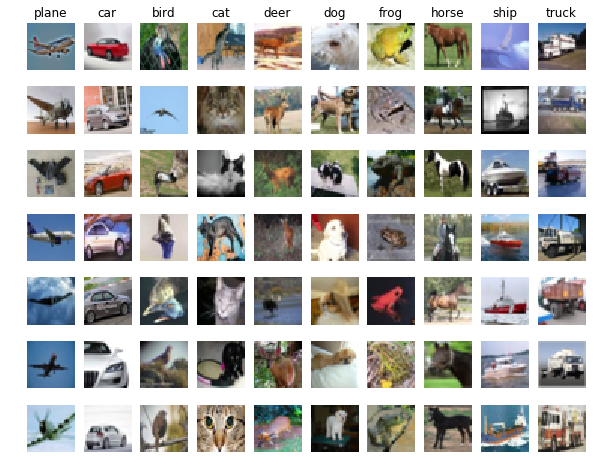

In [8]:
# Visualize some examples from the dataset.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [9]:
# Subsample the data (Toy Dataset)
num_training = 5000
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

num_test = 500
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

In [10]:
# Reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
print X_train.shape, X_test.shape

(5000, 3072) (500, 3072)


## The KNN Classifier Overview

1. First we must compute the distances between all test examples and all train examples. 
2. Given these distances, for each test example we find the k nearest examples and have them vote for the label

If there are **Ntr** training examples and **Nte** test examples, this stage should result in a **Nte x Ntr** matrix where each element (i,j) is the distance between the i-th test and j-th train example.

### Method: Calculating Euclidean Distance Iteratively
- Slow Iterative Code

In [18]:
from models_utils.classifiers import KNearestNeighbor

# Create a kNN classifier instance. 
# the Classifier simply remembers the data and does no further processing 

classifier = KNearestNeighbor()
classifier.train(X_train, y_train)

# Testing implementation:
dists = classifier.euclidean_dist_iterative(X_test)
print dists.shape

(500, 5000)


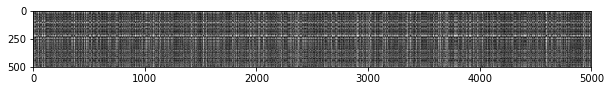

In [19]:
# We can visualize the distance matrix: each row is a single test example and
# its distances to training examples
plt.imshow(dists, interpolation='none')
plt.show()

* Distinctly bright rows may be due to extreme luminosity values of test data (very bright, ver dark). We can expect that most testing images will have an average grey pixel value. 

* For columns, it may be that the particular training image has extreme luminosity value.

In [20]:
# We use k = 1 (which is Nearest Neighbor).
y_test_pred = classifier.predict_labels(dists, k=1)

# Compute and print the fraction of correctly predicted examples
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print 'Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy)

Got 137 / 500 correct => accuracy: 0.274000


In [21]:
y_test_pred = classifier.predict_labels(dists, k=5)
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print 'Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy)

Got 139 / 500 correct => accuracy: 0.278000


- Not surprisingly, having a bigger voting pool of neighbor slightly improves accuracy

## Vectorized Code is better!

In [23]:
# Now lets speed up distance matrix computation by using partial vectorization
# with one loop. Implement the function euclidean_dist_partially_vectorized and run the
# code below:
dists_one = classifier.euclidean_dist_partially_vectorized(X_test)

# To ensure that our vectorized implementation is correct, we make sure that it
# agrees with the naive implementation. There are many ways to decide whether
# two matrices are similar; one of the simplest is the Frobenius norm. In case
# you haven't seen it before, the Frobenius norm of two matrices is the square
# root of the squared sum of differences of all elements; in other words, reshape
# the matrices into vectors and compute the Euclidean distance between them.
difference = np.linalg.norm(dists - dists_one, ord='fro')
print 'Difference was: %f' % (difference, )

Difference was: 0.000000


In [24]:
# Now implement the fully vectorized version inside euclidean_dist_vectorized
# and run the code
dists_two = classifier.euclidean_dist_vectorized(X_test)

# check that the distance matrix agrees with the one we computed before:
difference = np.linalg.norm(dists - dists_two, ord='fro')
print 'Difference was: %f' % (difference, )

Difference was: 0.000000


In [25]:
# Let's compare how fast the implementations are
def time_function(f, *args):
  """
  Call a function f with args and return the time (in seconds) that it took to execute.
  """
  import time
  tic = time.time()
  f(*args)
  toc = time.time()
  return toc - tic

two_loop_time = time_function(classifier.euclidean_dist_iterative, X_test)
print 'Two loop version took %f seconds' % two_loop_time

one_loop_time = time_function(classifier.euclidean_dist_partially_vectorized, X_test)
print 'One loop version took %f seconds' % one_loop_time

no_loop_time = time_function(classifier.euclidean_dist_vectorized, X_test)
print 'No loop version took %f seconds' % no_loop_time

Two loop version took 27.146279 seconds
One loop version took 27.535089 seconds
No loop version took 0.335079 seconds


### Cross-validation

We have implemented the k-Nearest Neighbor classifier but we set the value k = 5 arbitrarily. We will now determine the best value of this hyperparameter with cross-validation.

In [29]:
num_folds = 5
k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]


X_train_folds = np.array_split(X_train, num_folds)
y_train_folds = np.array_split(y_train, num_folds)


# A dictionary holding the accuracies for different values of k that we find
# when running cross-validation. After running cross-validation,
# k_to_accuracies[k] should be a list of length num_folds giving the different
# accuracy values that we found when using that value of k.
k_to_accuracies = {}

################################################################################
# Perform k-fold cross validation to find the best value of k. For each        #
# possible value of k, run the k-nearest-neighbor algorithm num_folds times,   #
# where in each case we will use all but one of the folds as training data     #
# and the last fold as a validation set. Store the accuracies for all fold     #
# and all values of k in the k_to_accuracies dictionary.                       #
################################################################################
cv_classifier = KNearestNeighbor()

for k in k_choices:
    accuracies_list = []
    for test_fold_num in range(num_folds):
        # Create training and testing sets
        X_train_fold = np.concatenate([fold for i, fold in enumerate(X_train_folds) if i != test_fold_num ])
        y_train_fold = np.concatenate([fold for i, fold in enumerate(y_train_folds) if i != test_fold_num ])
        X_test_fold  = X_train_folds[test_fold_num] 
        y_test_fold  = y_train_folds[test_fold_num]
        num_test_fold = y_test_fold.shape[0]
        
        # Training 
        cv_classifier.train(X_train_fold,y_train_fold)
        
        # Testing and storing accuracies 
        dists = cv_classifier.euclidean_dist_vectorized(X_test_fold)
        y_test_pred = cv_classifier.predict_labels(dists, k=k)
        num_correct = np.sum(y_test_pred == y_test_fold)
        accuracy = float(num_correct)/num_test_fold
        accuracies_list.append(accuracy)
        
    k_to_accuracies[k] = accuracies_list

# Print out the computed accuracies
for k in sorted(k_to_accuracies):
    for accuracy in k_to_accuracies[k]:
        print 'k = %d, accuracy = %f' % (k, accuracy)

k = 1, accuracy = 0.263000
k = 1, accuracy = 0.257000
k = 1, accuracy = 0.264000
k = 1, accuracy = 0.278000
k = 1, accuracy = 0.266000
k = 3, accuracy = 0.239000
k = 3, accuracy = 0.249000
k = 3, accuracy = 0.240000
k = 3, accuracy = 0.266000
k = 3, accuracy = 0.254000
k = 5, accuracy = 0.248000
k = 5, accuracy = 0.266000
k = 5, accuracy = 0.280000
k = 5, accuracy = 0.292000
k = 5, accuracy = 0.280000
k = 8, accuracy = 0.262000
k = 8, accuracy = 0.282000
k = 8, accuracy = 0.273000
k = 8, accuracy = 0.290000
k = 8, accuracy = 0.273000
k = 10, accuracy = 0.265000
k = 10, accuracy = 0.296000
k = 10, accuracy = 0.276000
k = 10, accuracy = 0.284000
k = 10, accuracy = 0.280000
k = 12, accuracy = 0.260000
k = 12, accuracy = 0.295000
k = 12, accuracy = 0.279000
k = 12, accuracy = 0.283000
k = 12, accuracy = 0.280000
k = 15, accuracy = 0.252000
k = 15, accuracy = 0.289000
k = 15, accuracy = 0.278000
k = 15, accuracy = 0.282000
k = 15, accuracy = 0.274000
k = 20, accuracy = 0.270000
k = 20, accu

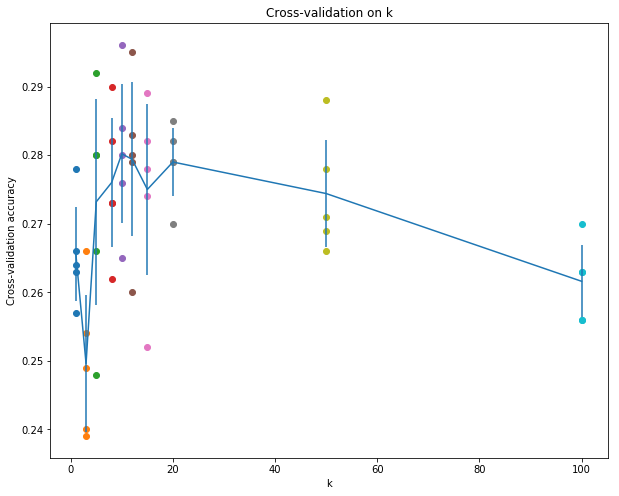

In [30]:
# plot the raw observations
for k in k_choices:
  accuracies = k_to_accuracies[k]
  plt.scatter([k] * len(accuracies), accuracies)

# plot the trend line with error bars that correspond to standard deviation
accuracies_mean = np.array([np.mean(v) for k,v in sorted(k_to_accuracies.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(k_to_accuracies.items())])
plt.errorbar(k_choices, accuracies_mean, yerr=accuracies_std)
plt.title('Cross-validation on k')
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.show()

In [35]:
# Based on the cross-validation results above, choose the best value for k,   
# retrain the classifier using all the training data, and test it on the test
# data. You should be able to get above 28% accuracy on the test data.
best_k = 10


classifier = KNearestNeighbor()
classifier.train(X_train, y_train)
y_test_pred = classifier.predict(X_test, k=best_k)

# Compute and display the accuracy
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print 'Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy)

Got 141 / 500 correct => accuracy: 0.282000
